# Rolling up Offer and Transaction Data for Clustering 

In [1]:
import pandas as pd
import os
import pandasql as ps

In [ ]:
os.chdir('path to whatever folder contains transaction_transformed, offers_transformed csvs')

## Query for Offer Related Information

In [5]:
offers = pd.read_csv('offers_transformed.csv')

In [6]:
offers.head()

,Unnamed: 0,person,received,received time,offer_id,viewed,viewed time,completed,completed time,reward,transaction,transaction time,amount
0,0,78afa995795e4d85b5d9ceeca43f5fef,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,6.0,1,132.0,5.0,1,132.0,19.89
1,1,a03223e636434f42ac4c3df47e8bac43,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,6.0,0,NaN,NaN,0,NaN,NaN
2,2,a03223e636434f42ac4c3df47e8bac43,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,624.0,0,NaN,NaN,0,NaN,NaN
3,3,e2127556f4f64592b11af22de27a7932,1,0,2906b810c7d4411798c6938adc9daaa5,1,18.0,0,NaN,NaN,0,NaN,NaN
4,4,8ec6ce2a7e7949b1bf142def7d0e0586,1,0,fafdcd668e3743c1bb461111dcafc2a4,1,12.0,0,NaN,NaN,0,NaN,NaN


In [9]:
query = """
SELECT person, IFNULL(SUM(viewed), 0) as total_offer_views, IFNULL(SUM(completed), 0) as total_completed_offers, 
IFNULL(SUM(reward), 0) as total_rewards_received, IFNULL(AVG(amount), 0) as average_offer_payment
FROM offers
GROUP BY person
"""

offer_rollup = ps.sqldf(query = query)

## Transaction Queries

In [10]:
transactions = pd.read_csv("transactions_transformed.csv")

In [31]:
num_transactions = transactions.groupby(by = 'person').sum()[['transaction']].reset_index().rename({'transaction':'number_of_transactions'}, axis = 1)

In [12]:
query = """
SELECT person, IFNULL(AVG(amount), 0) as average_transaction_amount
FROM transactions
GROUP BY person
"""
average_transactions = ps.sqldf(query = query)

## Join Data Together

In [44]:
query = """
SELECT t1.person as person_id, * 
FROM offer_rollup t1 JOIN num_transactions t2 on t1.person = t2.person 
JOIN average_transactions t3 ON t1.person = t3.person
"""

full_profile_clustering = ps.sqldf(query = query)

In [46]:
full_profile_clustering.drop(columns = 'person', inplace = True)

## Checking Correlation

In [48]:
# check for correlations briefly
full_profile_clustering.corr()

,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount
total_offer_views,1.000000,0.884072,0.741315,0.072778,0.710665,0.112218
total_completed_offers,0.884072,1.000000,0.842742,0.165653,0.790618,0.214658
total_rewards_received,0.741315,0.842742,1.000000,0.153502,0.645227,0.203849
average_offer_payment,0.072778,0.165653,0.153502,1.000000,0.073094,0.752698
number_of_transactions,0.710665,0.790618,0.645227,0.073094,1.000000,0.038310
average_transaction_amount,0.112218,0.214658,0.203849,0.752698,0.038310,1.000000


## Export Data

In [52]:
full_profile_clustering.to_csv('user_activity_rollup.csv', index = False)

## KMeans Clustering

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#bring in rolled up data by person id
cluster_data = pd.read_csv("user_activity_rollup.csv")

In [9]:
cluster_data.head()

,person_id,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount
0,0009655768c64bdeb2e877511632db8f,4,3,9.0,10.983333,8,15.950000
1,00116118485d4dfda04fdbaba9a87b5c,4,0,0.0,0.000000,3,1.363333
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,13.0,18.676667,6,16.918333
3,0020c2b971eb4e9188eac86d93036a77,6,5,18.0,17.396000,11,22.633636
4,0020ccbbb6d84e358d3414a3ff76cffd,4,3,13.0,12.166667,12,12.837500


In [6]:
cluster_data.describe()

,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount
count,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000,16572.000000
mean,5.847152,4.066920,20.093230,14.697263,10.603005,13.976243
std,5.067047,5.434291,32.699255,26.159824,7.428972,17.716807
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.050000
25%,3.000000,1.000000,2.000000,2.790000,5.000000,3.313000
50%,4.000000,2.000000,10.000000,12.453750,9.000000,12.320909
75%,7.000000,5.000000,24.000000,20.570833,14.000000,20.551259
max,75.000000,75.000000,660.000000,1015.730000,88.000000,533.606154


In [10]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

#Split data into train and test for clustering
X = cluster_data.drop(columns = "person_id")
y = cluster_data["person_id"]

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .2, random_state = 1)

In [41]:
#Performing kmeans and attempting different numbers of clusters

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 12)]

In [42]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

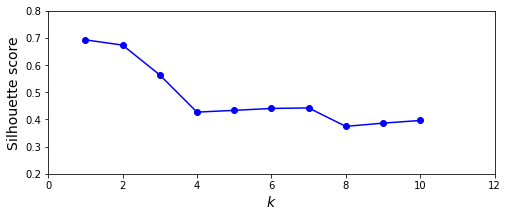

In [46]:
#Plotting the scores for each number of calculated Kmeans clusters

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([0, 12, 0.2, .8])
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [47]:
inertias = [model.inertia_ for model in kmeans_per_k]

print(inertias)

[36089301.42976263, 25036519.448413827, 17101502.754227713, 13000926.699383346, 10002075.32737758, 8465903.199089212, 7206559.94732892, 6396536.362716703, 5884194.08113364, 5191938.905362511, 4656316.060083777]


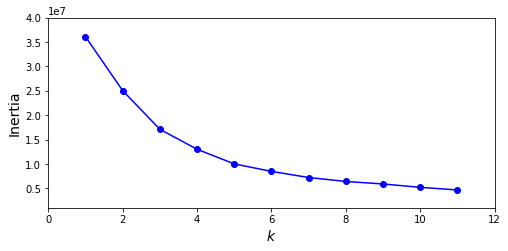

In [53]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 12), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([0, 12, 1000000, 40000000])
#save_fig("inertia_vs_k_plot")
plt.show()

Based on the inertia and the the silhouette scores of the different number of clusters, the best number of clusters is 2 or 3 clusters. 2 clusters have the largest silhouette score (not counting 1), and 3 is the elbow point of the models inertia and also has a higher silhouette score.

## Standardization of clusters

In [60]:
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix

scaler = StandardScaler()
scaled_model = scaler.fit_transform(X)


In [118]:
columns = scaled_model.columns
columns

log_transform = [np.log(scaled_model["{}".format(name)]) for name in columns]
#df['logStreams'] = np.log10(df['Streams'])

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [111]:
X.head()

,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount
0,4,3,9.0,10.983333,8,15.950000
1,4,0,0.0,0.000000,3,1.363333
2,5,3,13.0,18.676667,6,16.918333
3,6,5,18.0,17.396000,11,22.633636
4,4,3,13.0,12.166667,12,12.837500


In [114]:
log = pd.DataFrame(log_transform)
log

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>,
        <AxesSubplot:xlabel='5', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>,
        <AxesSubplot:xlabel='5', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>,
        <AxesSubplot:xlabel='4', ylabel='2'>,
        <AxesSubplot:xlabel='5', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3'

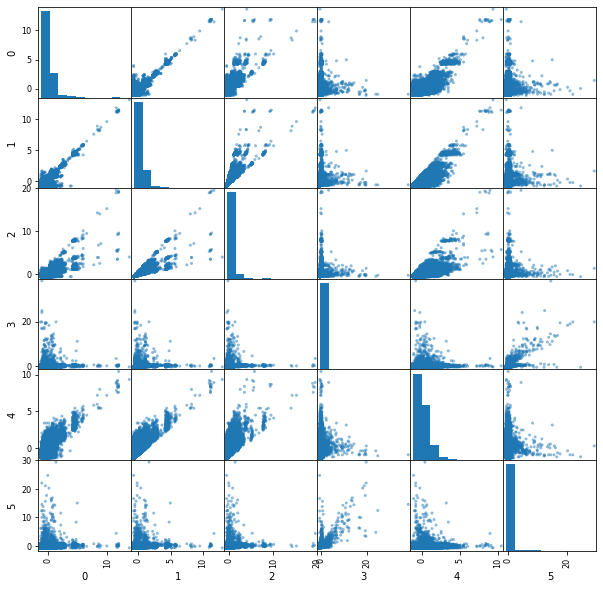

In [96]:

scatter_matrix(pd.DataFrame(scaled_model), figsize = (10,10))

In [99]:
pd.DataFrame(scaled_model).head()

,0,1,2,3,4,5
0,-0.364553,-0.196337,-0.339260,-0.141975,-0.350396,0.111409
1,-0.364553,-0.748404,-0.614504,-0.561843,-1.023457,-0.711939
2,-0.167194,-0.196337,-0.216930,0.152124,-0.619621,0.166067
3,0.030166,0.171707,-0.064017,0.103167,0.053440,0.488669
4,-0.364553,-0.196337,-0.216930,-0.096739,0.188053,-0.064277


In [62]:
#Performing kmeans and attempting different numbers of clusters

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(scaled_model)
                for k in range(1, 12)]

In [63]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(scaled_model, model.labels_)
                     for model in kmeans_per_k[1:]]

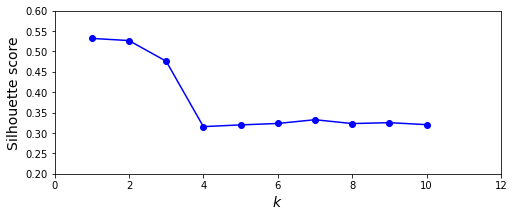

In [69]:
#Plotting the scores for each number of calculated Kmeans clusters

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([0, 12, 0.2, .6])
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [65]:
inertias = [model.inertia_ for model in kmeans_per_k]

print(inertias)

[99431.9999999998, 67362.07336987749, 51953.73991676984, 38921.176107175284, 33245.615993468266, 29856.930672350223, 26810.670150931608, 24025.207689676085, 22269.87473205905, 20903.64006936289, 19886.00482731248]


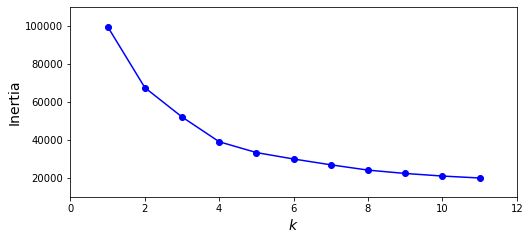

In [68]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 12), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([0, 12, 10000, 110000])
#save_fig("inertia_vs_k_plot")
plt.show()

### Clustering results

In [70]:
kmeans2 = KMeans(n_clusters = 2)
kmeans3 = KMeans(n_clusters = 3)

kmeans2.fit_predict(scaled_model)
kmeans3.fit_predict(scaled_model)

labels2 = kmeans2.labels_
labels3 = kmeans3.labels_

cluster_data2 = cluster_data
cluster_data2['cluster_num'] = labels2
cluster_data2.head()


,person_id,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount,cluster_num
0,0009655768c64bdeb2e877511632db8f,4,3,9.0,10.983333,8,15.950000,1
1,00116118485d4dfda04fdbaba9a87b5c,4,0,0.0,0.000000,3,1.363333,1
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,13.0,18.676667,6,16.918333,1
3,0020c2b971eb4e9188eac86d93036a77,6,5,18.0,17.396000,11,22.633636,1
4,0020ccbbb6d84e358d3414a3ff76cffd,4,3,13.0,12.166667,12,12.837500,1


In [71]:
#Group by the clusters 
cluster_data2.groupby('cluster_num').mean()

,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount
cluster_num,,,,,,
0,12.861799,12.348480,63.172987,26.336937,20.258853,22.880141
1,4.174352,2.091996,9.819894,11.921521,8.300351,11.852909


In [72]:
cluster_data3 = cluster_data
cluster_data3['cluster_num'] = labels3
cluster_data3.head()

,person_id,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount,cluster_num
0,0009655768c64bdeb2e877511632db8f,4,3,9.0,10.983333,8,15.950000,0
1,00116118485d4dfda04fdbaba9a87b5c,4,0,0.0,0.000000,3,1.363333,0
2,0011e0d4e6b944f998e987f904e8c1e5,5,3,13.0,18.676667,6,16.918333,0
3,0020c2b971eb4e9188eac86d93036a77,6,5,18.0,17.396000,11,22.633636,0
4,0020ccbbb6d84e358d3414a3ff76cffd,4,3,13.0,12.166667,12,12.837500,0


In [73]:
#Group by the clusters
cluster_data3.groupby('cluster_num').mean()

,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount
cluster_num,,,,,,
0,4.170342,2.090664,9.821212,12.055881,8.280215,11.979367
1,13.029553,12.505622,64.029875,18.989768,20.578220,18.237202
2,6.787500,6.200000,28.275000,289.403160,10.900000,182.124307


## Linear Discriminant Analysis

Now we compute the linear discriminant analysis based off the clusters made previously

In [168]:
#first we want to add in the discrimnant variables of the dataset. Age, income, gender, and when they became a member
profile = pd.read_csv("https://raw.githubusercontent.com/mitchell-jones/starbucks-6276/main/data/processed/profile_transformed.csv")

#We remove the extra index and the scaled membership days and when they became a member
profile = profile.drop(columns = ["Unnamed: 0", "membership_length_scaled", "became_member_on", "became_member_on_converted"])
profile.head()

,gender,age,id,income,membership_length_days
0,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,376
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443
2,M,68,e2127556f4f64592b11af22de27a7932,70000.0,91
3,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,167
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257


In [180]:
#Merge the profile data to the cluster result data
lda_data = profile.merge(cluster_data3, how = "inner", left_on = "id", right_on = "person_id")

#remove repeat of id
lda_data = lda_data.drop(columns = "id")


In [184]:
#since we don't have enough info on "other" in gender to create a conclusive analysis, we will remove it and convert gender into a binary variable
lda_data.gender.value_counts()

# converting to binary data for easier analysis
df_one = pd.get_dummies(lda_data["gender"])

 
# display result
df_two = pd.concat((df_one, lda_data), axis=1)
df_two = df_two.drop(["gender", 'O'], axis=1)
df_two = df_two.drop(["M"], axis=1)
#convert binary data so if gender = 1 is female and gender = 0 is male
lda_updated = df_two.rename(columns={"F": "gender"})

lda_updated.head()


,gender,age,income,membership_length_days,person_id,total_offer_views,total_completed_offers,total_rewards_received,average_offer_payment,number_of_transactions,average_transaction_amount,cluster_num
0,1,55,112000.0,376,0610b486422d4921ae7d2bf64640c50b,0,1,5.0,23.220000,3,25.670000,0
1,1,75,100000.0,443,78afa995795e4d85b5d9ceeca43f5fef,4,3,20.0,21.110000,8,22.623750,0
2,0,68,70000.0,91,e2127556f4f64592b11af22de27a7932,3,2,7.0,18.420000,4,19.037500,0
3,0,65,53000.0,167,389bc3fa690240e798340f5a15918d5c,14,14,64.0,12.329286,14,12.329286,1
4,0,58,51000.0,257,2eeac8d8feae4a8cad5a6af0499a211d,2,1,2.0,7.140000,4,3.905000,0


In [245]:
#Create X and y for lda 
#For LDA we want to focus on the discriminant variables and their relation to the cluster numbers
y = lda_updated.cluster_num
X = lda_updated[["gender", "age", "income", "membership_length_days"]]

In [246]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create the lda model
lda = LinearDiscriminantAnalysis()

#Define the evaluation method using kfolds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)

In [233]:
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [247]:
# evaluate model
scores = cross_val_score(estimator = lda, X = X, y = y,
                         scoring='accuracy',
                         cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.785 (0.000)


In [244]:
# Evaluate result
means = pd.DataFrame(lda.means_, columns = ["gender", "age", "income", "membership_length_days"])

round(means, 3)

,gender,age,income,membership_length_days
0,0.398,53.874,64233.923,503.843
1,0.468,55.796,68517.105,623.907
2,0.538,58.312,80037.500,540.875


1. Age doesnt seem to influence behavior that much. 
2. Income does separate cluster 2 from the others.
3. Cluster 1 has longer membership
4. Cluster 0 is closer to male